In [57]:
from gzip import compress as _gzip_compress
from itertools import chain
from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
df = pd.read_csv('/ssd/projetos/gzip_clustering/data/bbc-news-data.csv', sep="\t")
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [49]:
dataset = df[["category", "title", "content"]]
dataset.head()

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [50]:
y = LabelEncoder().fit_transform(dataset["category"])
X_train, X_test, y_train, y_test = train_test_split(dataset["content"], y, test_size=0.3, shuffle=True)
# N = 200
# X_train, X_test, y_train, y_test = X_train[:N], X_test[:N], y_train[:N], y_test[:N]

In [51]:
@lru_cache(maxsize=2048)
def gzip_compress(x):
    return len(_gzip_compress(x.encode()))

def NCD(xs):
    x1, x2 = xs
    Cx1 = gzip_compress(x1)
    Cx2 = gzip_compress(x2)
    Cx1x2 = gzip_compress(f"{x1} {x2}")
    return round((Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2), 5)

In [52]:
# X_distance_1 = np.array([NCD((x1, x2)) for x1, x2 in product(X_train, repeat=2)]).reshape(-1, len(X_train))
# X_test_distance_1 = np.array([NCD((x1, x2)) for x1 in X_test for x2 in X_train]).reshape(-1, len(X_train))

In [53]:
# with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
#     X_distance_2 = list(executor.map(NCD, product(X_train, repeat=2), chunksize=30))
#     X_distance_2 = np.array(X_distance_2).reshape(-1, len(X_train))

#     X_test_distance_2 = list(executor.map(NCD, ((x1, x2) for x1 in X_test for x2 in X_train), chunksize=30))
#     X_test_distance_2 = np.array(X_test_distance_2).reshape(-1, len(X_train))

In [54]:
def optimized_train_matrix(lst):
    flat_list = list(chain.from_iterable(lst))
    n = int(np.sqrt(len(flat_list) * 2))
    matrix = np.zeros((n, n))
    matrix[np.tril_indices_from(matrix, k=0)] = flat_list
    matrix += matrix.T
    matrix[np.diag_indices_from(matrix)] /= 2
    return matrix

def calculate(data):
    i, x1 = data
    return [NCD((x1, x2)) for x2 in X_train[:(i+2)-1]]

def train(X_train):
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        return optimized_train_matrix(executor.map(calculate, enumerate(X_train), chunksize=30))

def infer(X_test, X_train):
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        X_test_distance = list(executor.map(NCD, ((x1, x2) for x1 in X_test for x2 in X_train), chunksize=30))
        return np.array(X_test_distance).reshape(-1, len(X_train))

X_distance = train(X_train)
X_test_distance = infer(X_test, X_train)

In [55]:
# print(np.array_equal(X_distance_1, X_distance_2))
# print(np.array_equal(X_distance, X_distance_1))
# print(np.array_equal(X_distance, X_distance_2))

# print(np.array_equal(X_test_distance, X_test_distance_1))
# print(np.array_equal(X_test_distance, X_test_distance_1))

In [56]:
neigh = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
neigh.fit(X_distance, y_train)
print(f"{round(neigh.score(X_test_distance, y_test) * 100, 2)}%")

92.81%


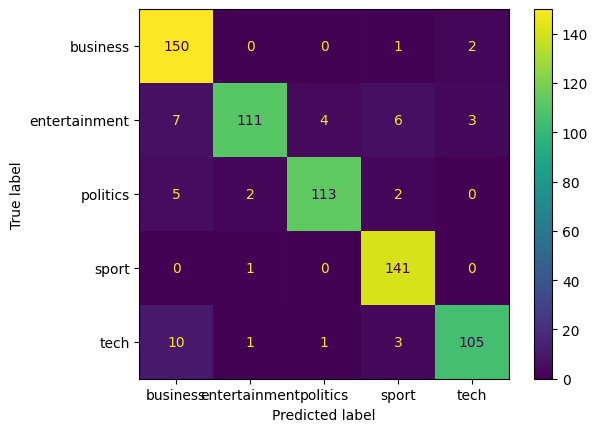

In [64]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, neigh.predict(X_test_distance)),
    display_labels=np.unique(dataset["category"])
)
cmd.plot()